## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. (`1_calibration_camera_chessboard.jpg`)
2. Apply a distortion correction to raw images. (`2_undist.jpg`)
3. Use color transforms, gradients, etc., to create a thresholded binary image. (`3_masking.jpg`)
4. Apply a perspective transform to rectify binary image ("birds-eye view"). (`4_warp.jpg`)
5. Detect lane pixels and fit to find the lane boundary. (`5_lane_pixel_fit.jpg`)
6. Determine the curvature of the lane and vehicle position with respect to center. (`6_curvature.jpg`)
7. Warp the detected lane boundaries back onto the original image. (`7_warp_back.jpg`)
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Each step has its corresponding output image (`*.jpg`) stored in directory `output_images/`

Detailed info of techniques can be found in `README.md` file

In [1]:
import numpy as np
from numpy.linalg import inv
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os.path
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

---
## 1. Compute the camera calibration using chessboard images
First find the corner points in the chessboard images

In [2]:
notCalibrated = True
calibration_file_path = "./calibration_wide/wide_dist_pickle.p"
if os.path.exists(calibration_file_path):
    print("Camera has been calibrated before. Load mtx and dist from {}".format(calibration_file_path))
    dist_pickle = pickle.load( open( calibration_file_path, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    notCalibrated = False

if notCalibrated:
    nx = 9
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    img_num = len(images)

    count=0
    # Step through the list and search for chessboard corners
    for fname in images:
        print("Processing {}".format(fname))
        plt.figure(figsize=(15,150))
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.subplot(img_num,1,count+1)
            plt.imshow(img)
            count+=1

    plt.tight_layout()

Camera has been calibrated before. Load mtx and dist from ./calibration_wide/wide_dist_pickle.p


Then calculate the Transform and Distortion Matrix

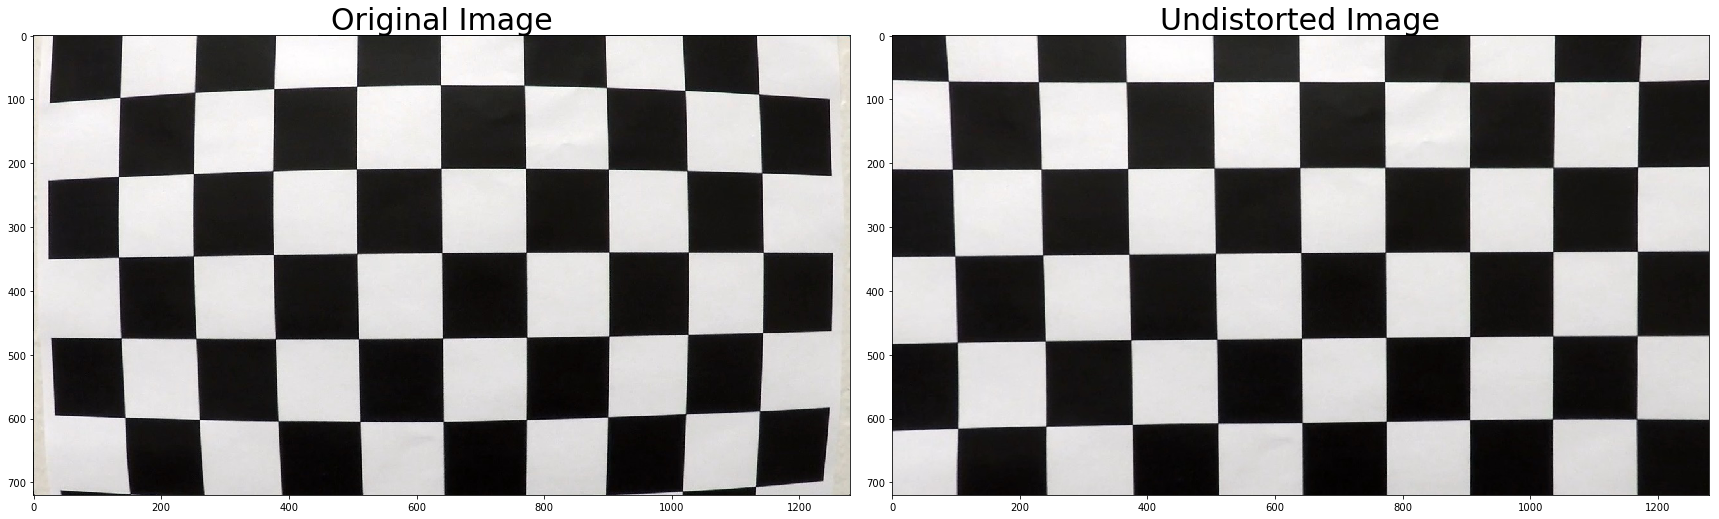

In [3]:
if notCalibrated:
    # Do camera calibration given object points and image points
    print("Calibrating camera")
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "./calibration_wide/wide_dist_pickle.p", "wb" ) )

# Test undistortion on an image
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

undst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('./output_images/test_undist.jpg',undst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

plt.savefig('./output_images/1_calibration_camera_chessboard.jpg')

---
## 2. Apply a distortion correction to raw images.

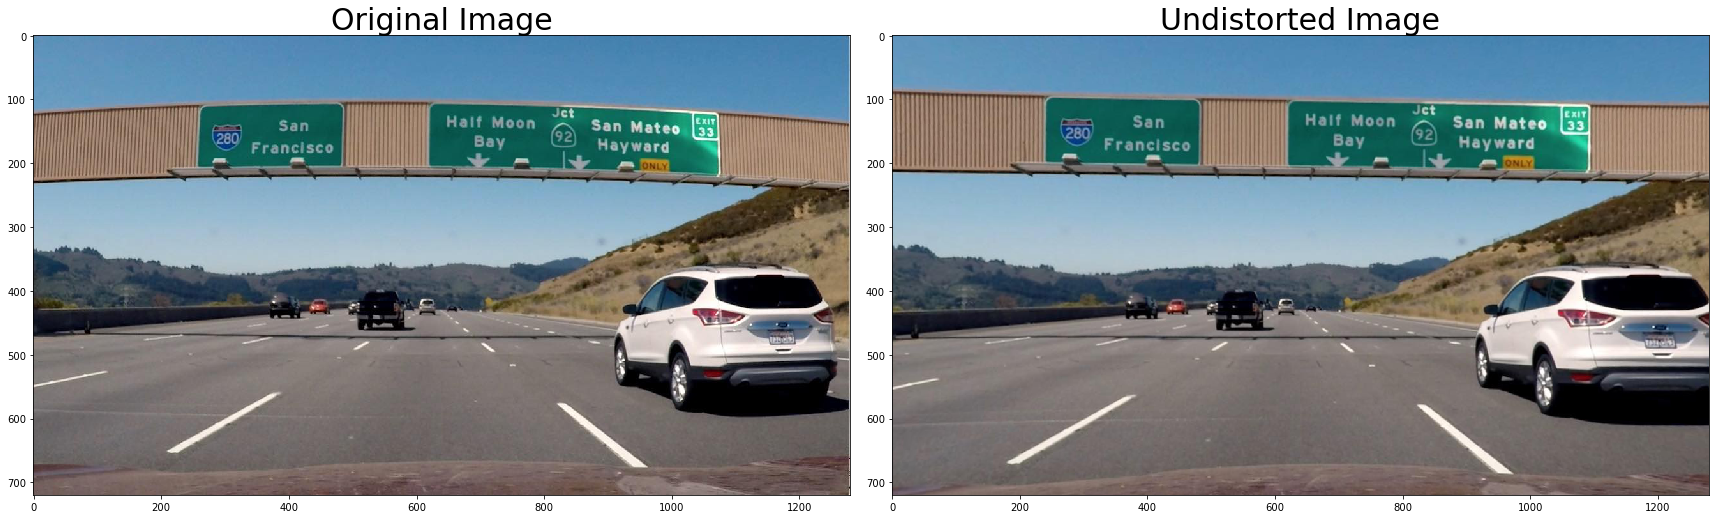

In [4]:
image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image',fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image',fontsize=30)
plt.savefig('./output_images/2_undist.jpg')

---
## 3. Create a thresholded binary image by *`Color`*, *`Gradients Magnitude`*, and *`Gradients Directions`* masking funcitons
**[Def]:** First, I defined those masking functions

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel>thresh[0])&(scaled_sobel<thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel>mag_thresh[0])&(scaled_sobel<mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    theta = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(gray)
    binary_output[(theta>thresh[0])&(theta<thresh[1])] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0])&(s<=thresh[1])] = 1
    return binary_output

def bright_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the L channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(l>thresh[0])&(l<=thresh[1])] = 1
    return binary_output

def combined_binary_mask(img, ksize=3, mag_low=80, mag_high=255, dir_low=0.0, dir_high=1.2,\
                         hls_low=100, hls_high=255, bright_low=75, bright_high=255):
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(dir_low, dir_high))
    hls_binary = hls_select(img, thresh=(hls_low, hls_high))
    bright_binary = bright_select(img, thresh=(bright_low, bright_high))
    combined = np.zeros_like(mag_binary)
    combined[((mag_binary == 1) & (dir_binary == 1)) | ((hls_binary == 1) & (dir_binary == 1) & (bright_binary == 1))] = 1
    return combined


Then I used **widgets** to help tuning the parameters

<function __main__.interactive_mask>

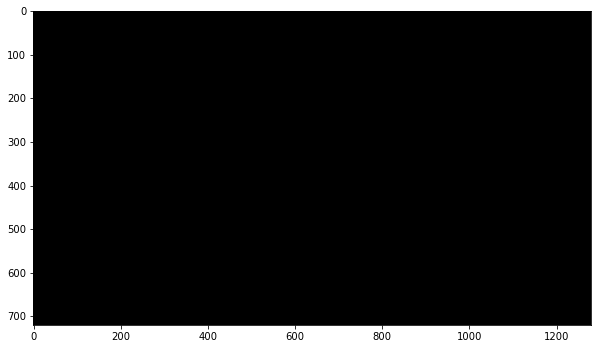

In [6]:
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

#image = mpimg.imread('./test_images/test1.jpg')
image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

def interactive_mask(ksize, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high, bright_low, bright_high):
    combined = combined_binary_mask(image,ksize, mag_low, mag_high, dir_low, dir_high,\
                                    hls_low, hls_high, bright_low, bright_high)
    plt.figure(figsize=(10,10))
    plt.imshow(combined,cmap='gray')
    
interact(interactive_mask, ksize=(1,31,2), mag_low=(0,255), mag_high=(0,255),\
         dir_low=(0, np.pi/2), dir_high=(0, np.pi/2), hls_low=(0,255),\
         hls_high=(0,255), bright_low=(0,255), bright_high=(0,255))

**[Example]:** Apply to an example

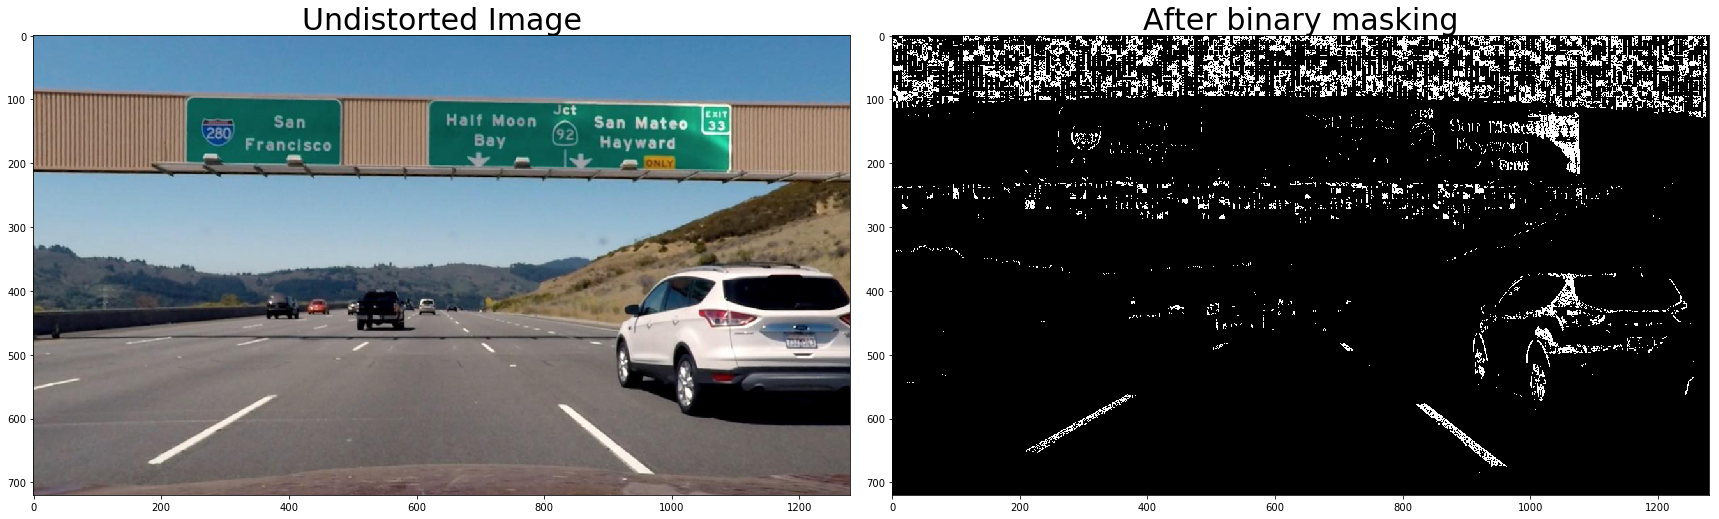

In [7]:
image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
combined = combined_binary_mask(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image',fontsize=30)
ax2.imshow(combined,cmap='gray')
ax2.set_title('After binary masking',fontsize=30)
plt.savefig('./output_images/3_masking.jpg')

---
## 4. Apply a perspective transform to rectify binary image ("birds-eye view")
**[Def]:** `perspective_warper` is defined.

**[Example]:** Then applying it to the example image.

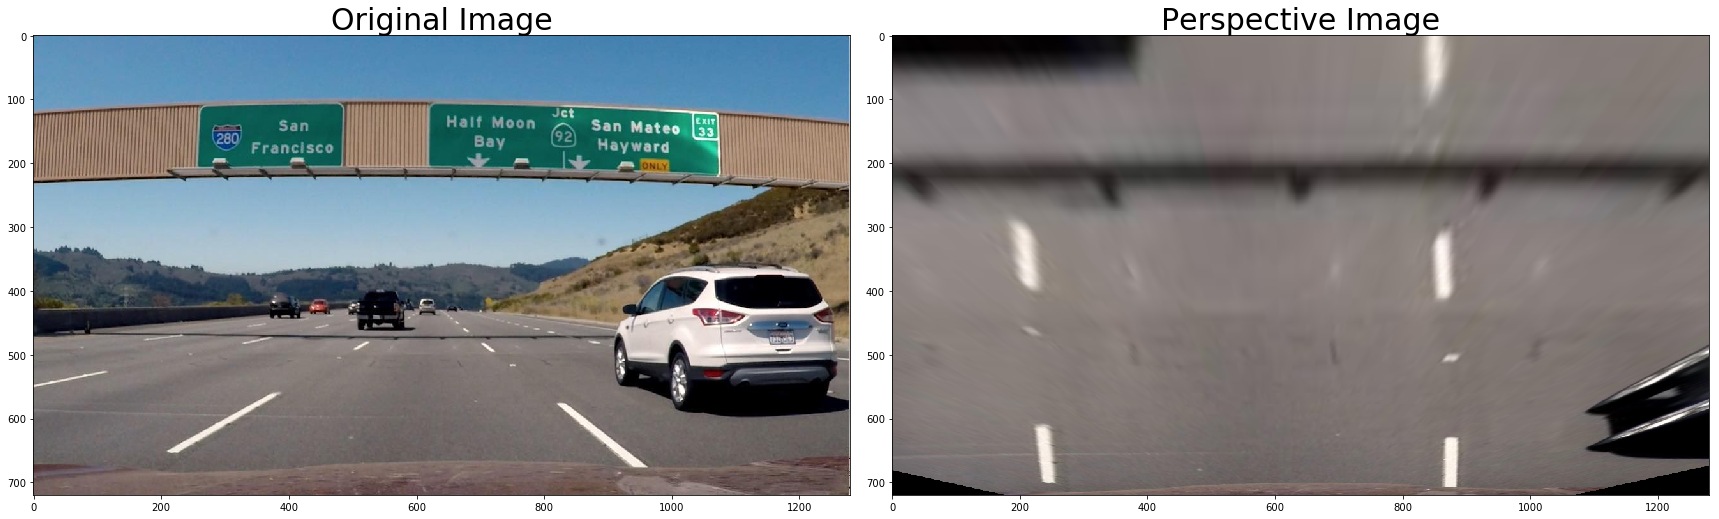

In [8]:
# First define the src and dst pts
src = np.float32(
[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

def perspective_warper(img,src,dst):
    warpM = cv2.getPerspectiveTransform(src,dst)
    height, width = img.shape[0:2]
    return (cv2.warpPerspective(img, warpM, (width,height), flags=cv2.INTER_LINEAR, borderValue=(0, 0, 0)), warpM)

image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
img_size = undist.shape[0:2]
img_size = img_size[::-1]

perspective_img, warpM = perspective_warper(undist,src,dst)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(perspective_img)
ax2.set_title('Perspective Image', fontsize=30)
plt.savefig('./output_images/4_warp.jpg')

---
## 5. Detect lane pixels and fit to find the lane boundary. A *"Shared Polynomial Fitting"* method is used

**[Def]:** First I defined function to identify lane pixel

In [9]:
# the input argument of img is the perspective binary image
# the outputs are left and right pixels of index
def identify_lane_pixel(img, lcenter_in, rcenter_in, win_num=9, win_half_width=150, start_from_button=False):
    assert(img.ndim==2)
    assert(len(lcenter_in)==win_num)
    assert(len(rcenter_in)==win_num)
    lcenter_out = np.copy(lcenter_in)
    rcenter_out = np.copy(rcenter_in)
    height, width = img.shape[0:2]
    win_height = np.ceil(height/win_num).astype(int)
    pix_num_th = int(win_height/6)
    #print("pix_num_th=",pix_num_th)
    l_mask = np.ones_like(img,dtype=bool)
    r_mask = np.ones_like(img,dtype=bool)
    i=0
    for e_idx in range(height, 0, -win_height):
        s_idx = np.max([e_idx - win_height, 0])
        win_img = img[s_idx:e_idx,:]
        win_hist = np.sum(win_img,axis=0)
        if ((not start_from_button) or i==0):
            lc = lcenter_in[i]
            rc = rcenter_in[i]
        else:
            lc = lcenter_out[i-1]
            rc = rcenter_out[i-1]
        # update the lcenter
        if (np.max(win_hist[lc-win_half_width:lc+win_half_width])>pix_num_th):
            lc = np.argmax(win_hist[lc-win_half_width:lc+win_half_width])+lc-win_half_width
        lcenter_out[i] = lc
        l_mask[s_idx:e_idx, np.max([lc-win_half_width,0]):np.min([lc+win_half_width,width])] = False
        # update the rcenter
        if (np.max(win_hist[rc-win_half_width:rc+win_half_width])>pix_num_th):
            rc = np.argmax(win_hist[rc-win_half_width:rc+win_half_width])+rc-win_half_width
        rcenter_out[i] = rc
        r_mask[s_idx:e_idx, np.max([rc-win_half_width,0]):np.min([rc+win_half_width,width])] = False
        i+=1
    lpixel = np.logical_and(np.logical_not(l_mask),img.astype(bool))
    rpixel = np.logical_and(np.logical_not(r_mask),img.astype(bool))
    # get the index list
    (lpixely,lpixelx) = np.where(lpixel==True)
    (rpixely,rpixelx) = np.where(rpixel==True)
    return (lpixelx,lpixely,rpixelx,rpixely,lcenter_out,rcenter_out)

**[Def]:** Also defined function to calculate poly_fit parameters and the corresponding drawing pixels

In [10]:
def fit_lane(lpixelx,lpixely,rpixelx,rpixely,height):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lpixely, lpixelx, 2)
    right_fit = np.polyfit(rpixely, rpixelx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, height-1, height )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (left_fit,right_fit,left_fitx,right_fitx,ploty)

In [11]:
def fit_lane_shared_coeff(lpixelx,lpixely,rpixelx,rpixely,height):
    l_num = len(lpixelx)
    r_num = len(rpixelx)
    p=lpixelx
    q=rpixelx
    x=lpixely
    z=rpixely
    Ax=np.vstack((x**2,x,np.ones(l_num),np.zeros(l_num)))
    Az=np.vstack((z**2,z,np.zeros(r_num),np.ones(r_num)))
    A=np.hstack((Ax,Az)).T
    target=np.concatenate((p,q))
    param=np.dot(np.dot(inv(np.dot(A.T,A)),A.T),target)
    left_fit = [param[0],param[1],param[2]]
    right_fit = [param[0],param[1],param[3]]
    # Generate x and y values for plotting
    ploty = np.linspace(0, height-1, height )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return (left_fit,right_fit,left_fitx,right_fitx,ploty)

**[Example]:** Showing an example of identifying lane pixels and curves

lcenter=[ 353.  352.  360.  381.  366.  345.  379.  365.  389.]
rcenter=[  960.   960.  1030.  1030.  1030.  1030.  1030.  1127.  1149.]


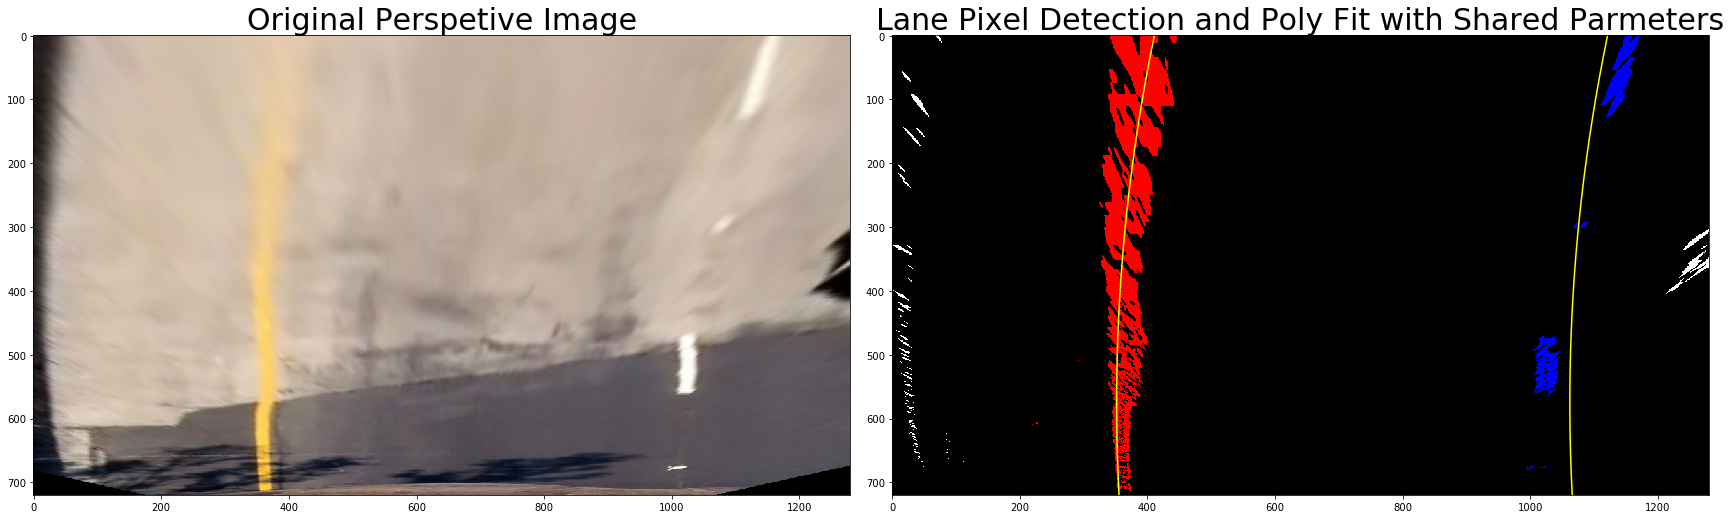

In [21]:
image = mpimg.imread('./test_images/test4.jpg')
#image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
height, width = image.shape[0:2]
# Pipeline so far:
# 1. camera distortion correctness
image = cv2.undistort(image, mtx, dist, None, mtx)
# 2. making
combined = combined_binary_mask(image)
# 3. perspective view
perspective_img, _ = perspective_warper(combined,src,dst)
# 4. lane line pixel identification
win_num=9
lcenter=np.ones(win_num)*int(1280/4)
rcenter=np.ones(win_num)*int(1280*3/4)
lpixelx,lpixely,rpixelx,rpixely,lcenter,rcenter = identify_lane_pixel(perspective_img, lcenter, rcenter, win_num=win_num, start_from_button=True)
print("lcenter={}\nrcenter={}".format(lcenter,rcenter))

# plotting area
image, _ = perspective_warper(image,src,dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Perspetive Image', fontsize=30)

out_img = np.dstack((perspective_img, perspective_img, perspective_img))*255
out_img[lpixely, lpixelx, :] = [255,0,0]
out_img[rpixely, rpixelx, :] = [0,0,255]
ax2.imshow(out_img)
ax2.set_title('Lane Pixel Detection and Poly Fit with Shared Parmeters', fontsize=30)

# 5. lane line curve fit
#left_fit,right_fit,left_fitx,right_fitx,ploty = fit_lane(lpixelx,lpixely,rpixelx,rpixely,height)
left_fit,right_fit,left_fitx,right_fitx,ploty = fit_lane_shared_coeff(lpixelx,lpixely,rpixelx,rpixely,height)

ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

plt.savefig('./output_images/5_lane_pixel_fit.jpg')

---
## 6. Determine the curvature of the lane and vehicle position with respect to center.

**[Def]:** Define the `curvature_position_calculating` function

In [13]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# left_fit and right_fit are the coefficients of left and right polynomial, respectively
#def curvature_calculating(left_fit,right_fit,height):
def curvature_position_calculating(left_fit,right_fit,height,width):
    a1, b1, c1 = left_fit
    a2, b2, c2 = right_fit
    r1 = ((1+(2*a1*height*ym_per_pix+b1)**2)**1.5)/(2*np.abs(a1))
    r2 = ((1+(2*a2*height*ym_per_pix+b2)**2)**1.5)/(2*np.abs(a2))
    left_fitx = a1*height**2 + b1*height + c1
    right_fitx = a2*height**2 + b2*height + c2
    pos = ((width - left_fitx - right_fitx)/2)*xm_per_pix
    return np.mean([r1,r2])/10, pos

**[Example]:** Showing an example of curvature and position of the vehicle calculating

720 1280


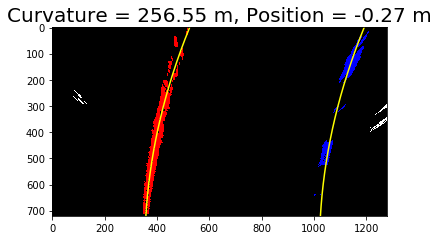

In [14]:
image = mpimg.imread('./test_images/test6.jpg')
#image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
height, width = image.shape[0:2]
print(height,width)
# Pipeline so far:
# 1. camera distortion correctness
image = cv2.undistort(image, mtx, dist, None, mtx)
# 2. making
combined = combined_binary_mask(image)
# 3. perspective view
perspective_img, _ = perspective_warper(combined,src,dst)
# 4. lane line pixel identification
win_num=9
lcenter=np.ones(win_num)*int(1280/4)
rcenter=np.ones(win_num)*int(1280*3/4)
lpixelx,lpixely,rpixelx,rpixely,lcenter,rcenter = identify_lane_pixel(perspective_img, lcenter, rcenter, win_num=win_num, start_from_button=True)
# 5. lane line curve fit
left_fit,right_fit,left_fitx,right_fitx,ploty = fit_lane_shared_coeff(lpixelx,lpixely,rpixelx,rpixely,height)
# 6. Curvature calculating
r, pos = curvature_position_calculating(left_fit,right_fit,height-1,width)
# plotting area
out_img = np.dstack((perspective_img, perspective_img, perspective_img))*255
out_img[lpixely, lpixelx, :] = [255,0,0]
out_img[rpixely, rpixelx, :] = [0,0,255]
plt.imshow(out_img)
plt.title('Curvature = {:.2f} m, Position = {:+.2f} m'.format(r,pos), fontsize=20)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.savefig('./output_images/6_curvature.jpg')

---
## 7. Warp the detected lane boundaries back onto the original image.

**[Def]:** Define the function of perspective_back, which inputs the undist and returns the lane-detected color image

In [15]:
def perspective_back(img, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warped = img[:,:,0]
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

**[Example]:** Showing an example that warp back onto the original image

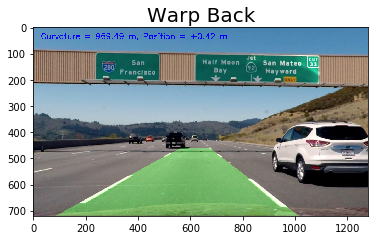

In [16]:
#image = mpimg.imread('./test_images/test1.jpg')
image = mpimg.imread('./test_images/signs_vehicles_xygrad.jpg')
height, width = image.shape[0:2]
# Pipeline so far:
# 1. camera distortion correctness
undist = cv2.undistort(image, mtx, dist, None, mtx)
# 2. making
combined = combined_binary_mask(undist)
# 3. perspective view
perspective_img, warpM = perspective_warper(combined,src,dst)
# 4. lane line pixel identification
win_num=9
lcenter=np.ones(win_num)*int(1280/4)
rcenter=np.ones(win_num)*int(1280*3/4)
lpixelx,lpixely,rpixelx,rpixely,lcenter,rcenter = identify_lane_pixel(perspective_img, lcenter, rcenter, win_num=win_num, start_from_button=True)
# 5. lane line curve fit
left_fit,right_fit,left_fitx,right_fitx,ploty = fit_lane_shared_coeff(lpixelx,lpixely,rpixelx,rpixely,height)
# 6. Curvature calculating
r, pos = curvature_position_calculating(left_fit,right_fit,height-1,width)
# 7. perspetive back and mix into original image
Minv = inv(warpM)
result = perspective_back(undist, Minv, left_fitx, right_fitx, ploty)
cv2.putText(result, 'Curvature = {:.2f} m, Position = {:+.2f} m'.format(r,pos), (30, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
plt.imshow(result)
plt.title('Warp Back',fontsize=20)
plt.savefig('./output_images/7_warp_back.jpg')

---
## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
**[Def]:** First, I concatenate pipeline functions to a single function for a given image

In [17]:
win_num=9
# the initial start points of lcenter and rcenter
lcenter=np.ones(win_num)*int(1280/4)
rcenter=np.ones(win_num)*int(1280*3/4)
firstFrame = True

# other defined parameters are
# camera calibration: mtx, dist
# perspetive warp pts: src, dst
# perspetive matrix: warpM, Minv
# pixel to real meter mapping: ym_per_pix and xm_per_pix

def process_image(img):
    global win_num
    global lcenter
    global rcenter
    global firstFrame
    
    if firstFrame==True:
        print("First Frame")
    
    ## the initial start points of lcenter and rcenter
    #lcenter=np.ones(win_num)*int(1280/4)
    #rcenter=np.ones(win_num)*int(1280*3/4)
    
    height, width = img.shape[0:2]
    # 1. camera distortion correctness
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # 2. making
    combined = combined_binary_mask(undist)
    # 3. perspective view
    perspective_img, warpM = perspective_warper(combined,src,dst)
    # 4. lane line pixel identification
    lpixelx,lpixely,rpixelx,rpixely,lcenter,rcenter = identify_lane_pixel(perspective_img,\
                                                                          lcenter, rcenter, win_num=win_num,\
                                                                          start_from_button=firstFrame)
    # 5. lane line curve fit
    left_fit,right_fit,left_fitx,right_fitx,ploty = fit_lane_shared_coeff(lpixelx,lpixely,rpixelx,rpixely,height)
    # 6. Curvature calculating
    r, pos = curvature_position_calculating(left_fit,right_fit,height-1,width)
    # 7. perspetive back and mix into original image
    Minv = inv(warpM)
    result = perspective_back(undist, Minv, left_fitx, right_fitx, ploty)
    cv2.putText(result, 'Curvature = {:.2f} m, Position = {:+.2f} m'.format(r,pos), (30, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    firstFrame = False
    return result

**[Example]:** Next, process the video

In [18]:
clip_output = './project_video_out.mp4'
clip1 = VideoFileClip('./project_video.mp4')
clip = clip1.fl_image(process_image) #NOTE: this function expects color images
clip.write_videofile(clip_output, audio=False)

First Frame
[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [03:47<00:00,  5.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 



In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clip_output))